In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../../MIMIC-IV/PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
sys.path.append('../../utils')
from dataset_loader import TidySequentialDataCSVLoader
from collections import OrderedDict
from itertools import combinations
%matplotlib inline

## Get the test data and the specific units that people were admitted to 

In [2]:
ts_feature_cols = ['Heart Rate', 
                    'Respiratory Rate', 
                    'O2 saturation pulseoxymetry',
       'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic',
        'Temperature Fahrenheit',
        'Height (cm)',
       'Respiratory Rate (Total)', 
       'Potassium (serum)',
       'Sodium (serum)', 
        'Chloride (serum)', 
        'Hematocrit (serum)',
       'Hemoglobin', 
        'Creatinine (serum)', 
        'Glucose (serum)', 
        'Magnesium', 
       'Phosphorous', 
        'Platelet Count', 
        'Glucose (whole blood)',
        'Daily Weight', 
        'Absolute Neutrophil Count',
        'Prothrombin time',
        'Fibrinogen',
        'PH (Arterial)',
        'PH (Venous)',
        'HCO3 (serum)',
        'Arterial O2 pressure',
        'Arterial CO2 Pressure',
        'Lactic Acid',
        'Albumin',
        'Calcium non-ionized',
        'C Reactive Protein (CRP)',
        'ALT',
        'AST',
        'Direct Bilirubin', 
        'Total Bilirubin',
        'Troponin-T',
        'Venous CO2 Pressure']

dem_cols = ['Age', 'is_gender_male', 'is_gender_unknown']
id_col = ['stay_id']
id_cols = ['subject_id', 'hadm_id', 'stay_id']

feature_cols = ts_feature_cols+dem_cols

data_dir = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/'
y_test_df = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y_test_df['los_ordinal_label'] = y_test_df['los_geq_3_days']+y_test_df['los_geq_7_days']+y_test_df['los_geq_11_days']

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)


test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)


In [3]:
test_x_NTD.shape

(10471, 24, 41)

In [4]:
y_test.shape

(10471,)

## Get the best PC-HMM ordinal regression model

In [5]:
# standardize data for PC-HMM
key_list = ['train', 'valid', 'test']
data_dict = dict.fromkeys(key_list)

X_test = np.expand_dims(test_x_NTD, 1)
data_dict['train'] = (X_test, y_test)
data_dict['valid'] = (X_test, y_test)
data_dict['test'] = (X_test, y_test)
data = custom_regression_dataset(data_dict=data_dict)

model_dir = '/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/'
best_model_weights = os.path.join(model_dir, 
                                  'semi-supervised-pchmm-lr=0.01-seed=152-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5')
n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])

model = HMM(states=n_states,
            observation_dist='NormalWithMissing',
            predictor_dist='OrderedLogistic')

model.build(data)
model.model.load_weights(best_model_weights)

x_test, y_test = data.test().numpy()
z_test = model.hmm_model.predict(x_test)

Class dist 0.7228535956451151


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


Training data shape: (10471, 1, 24, 41)


In [6]:
model._predictor.get_weights()

[array([[ 0.54270124],
        [ 7.0941496 ],
        [-4.4842753 ],
        [ 1.2462845 ],
        [-1.891097  ]], dtype=float32),
 array([0.27484828], dtype=float32)]

## Get the learned means and covariances of the 5 pc-hmm states for various covariates

In [7]:
def plotGauss2DContour(
        mu, Sigma,
        color='b',
        radiusLengths=[1.0, 3.0],
        markersize=3.0,
        ax_handle=None,
        label=''
        ):
    ''' Plot elliptical contours for provided mean mu, covariance Sigma.
    Uses only the first 2 dimensions.
    Post Condition
    --------------
    Plot created on current axes
    '''
    
    # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
    lambda_D, U_DD = np.linalg.eig(Sigma)
    
    # Verify orthonormal
    D = len(mu)
    assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
    # View eigenvector matrix as a rotation transformation
    rot_DD = U_DD

    # Prep for plotting elliptical contours
    # by creating grid of G different (x,y) points along perfect circle
    # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
    unit_circle_radian_step_size=0.03
    t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
    x_G = np.sin(t_G)
    y_G = np.cos(t_G)
    Zcirc_DG = np.vstack([x_G, y_G])

    # Warp circle into ellipse defined by Sigma's eigenvectors
    # Rescale according to eigenvalues
    Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
    # Rotate according to eigenvectors
    Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)

#     radius_lengths=[0.3, 0.6, 0.9, 1.2]
    radius_lengths=[1.0, 2.0, 3.0]

    # Plot contour lines across several radius lengths
    for r in radius_lengths:
        Z_DG = r * Zrotellipse_DG + mu[:, np.newaxis]
        ax_handle.plot(
            Z_DG[0], Z_DG[1], '.-',
            color=color,
            markersize=3.0,
            markerfacecolor=color,
            markeredgecolor=color, 
            label=label)
        
    return ax_handle

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    return ax

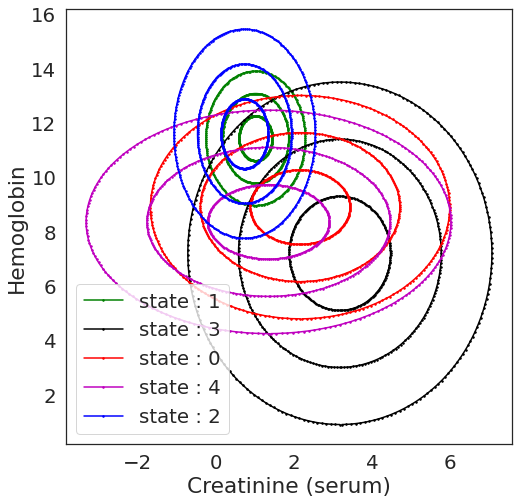

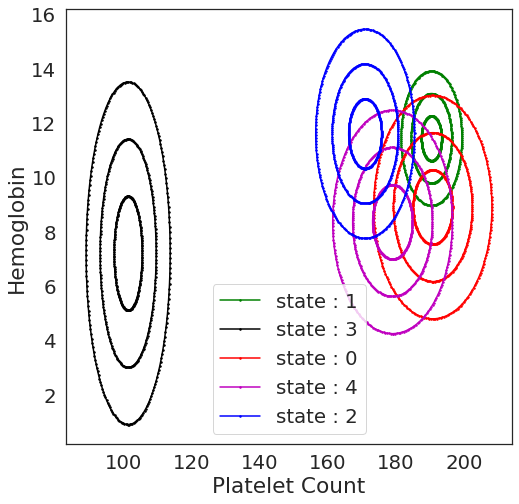

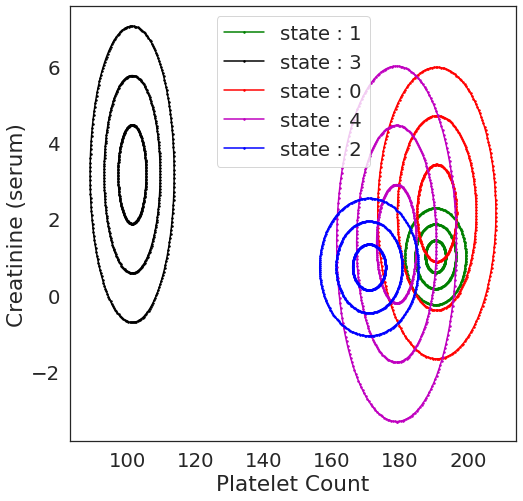

In [21]:
mu_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.mean().numpy()
cov_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.scale.numpy()
sorted_inds = np.argsort(np.squeeze(model._predictor.get_weights()[0]))[::-1] #np.array([4, 0, 3])
keep_features_cols = ['Hemoglobin', 'Creatinine (serum)', 'Platelet Count']

# keep_features_inds = np.where(np.isin(feature_cols, keep_features_cols))


keep_features_inds = [feature_cols.index(ii) for ii in keep_features_cols]
n_influential = 5 # number of influential states to retain from predictor
mu_KD_influential = np.squeeze(mu_all[sorted_inds[:n_influential], :][:, keep_features_inds])
cov_KD_influential = np.squeeze(cov_all[sorted_inds[:n_influential], :][:, keep_features_inds])
feature_cols_reindexed = np.array(feature_cols)[keep_features_inds[0]]

state_colors = ['r', 'g', 'b', 'k', 'm']
# cohort_names = ['z=4 (Risk state)', 'z=0 (Risk state)', 'z=3 (Normal)']
for combo in combinations(keep_features_cols, 2):
    f, axs = plt.subplots(1, 1, figsize=(8, 8))
    sns.set_style("white") # or use "white" if we don't want grid lines
    sns.set_context("notebook", font_scale=1.8)
    curr_feature_combo_inds = np.isin(keep_features_cols, combo)
    curr_feature_combo = np.array(keep_features_cols)[curr_feature_combo_inds]
    for kk in range(n_influential):
        mu = mu_KD_influential[kk, curr_feature_combo_inds][::-1]
        Sigma = np.diag(cov_KD_influential[kk, curr_feature_combo_inds][::-1])
        axs = plotGauss2DContour(mu, Sigma, ax_handle=axs, 
                                 label='state : %s'%sorted_inds[kk], 
                                 color=state_colors[sorted_inds[kk]]
                                )

    axs.legend()
    axs = legend_without_duplicate_labels(axs)
    axs.set_xlabel(curr_feature_combo[1])
    axs.set_ylabel(curr_feature_combo[0])
#     f.savefig('interpretability_%s_%s_EICU_improved_init.pdf'%(curr_feature_combo[0], 
#                                                  curr_feature_combo[1]), 
#               bbox_inches='tight', 
#               pad_inches=0)

## Plot average belief in each state for los label=0, 1, 2, 3

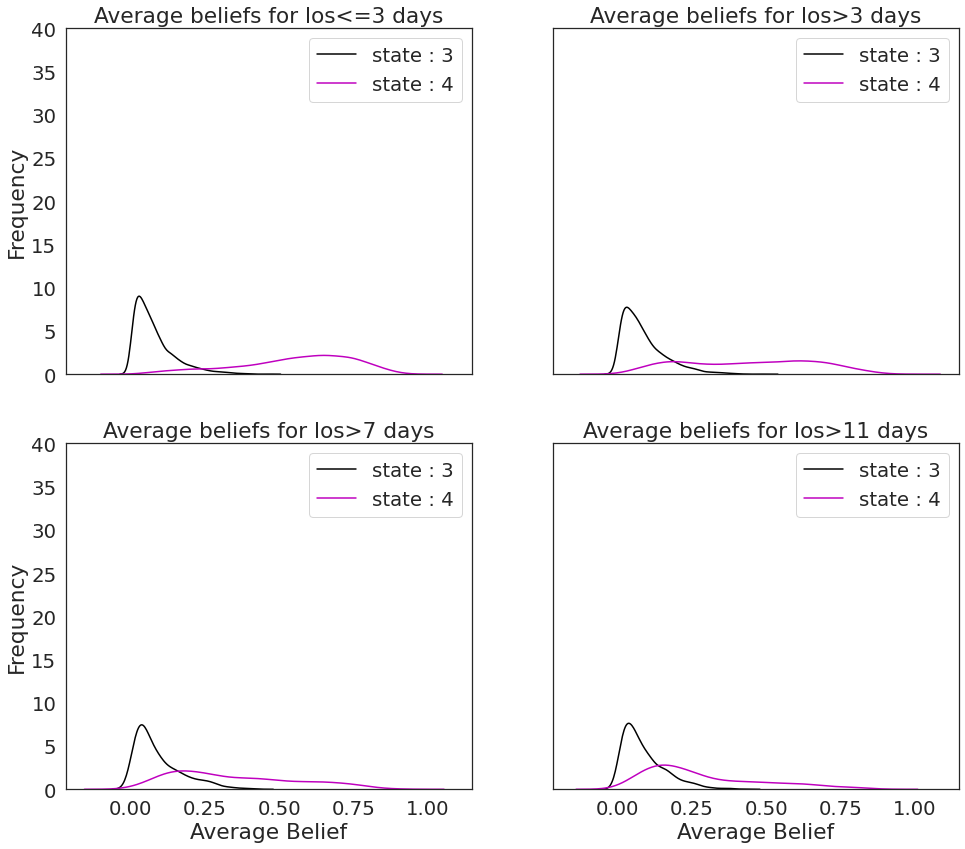

In [23]:
N, T, K = z_test.shape
bins = np.arange(0, 1, 0.05)
min_los_list = ['<=3', '>3', '>7', '>11']
f, axs = plt.subplots(2, 2, 
                      figsize=(16, 14),
                      sharey=True,
                      sharex=True
                     )
axs_list = axs.flatten()
for ordinal_label in range(4):
    
    curr_inds = y_test_df['los_ordinal_label']==ordinal_label
    curr_label_z_test_NTK = z_test[curr_inds]
    curr_label_avg_belief_NK = np.mean(curr_label_z_test_NTK, axis=1)
    for kk in [3, 4]:
#         axs_list[ordinal_label].hist(curr_label_avg_belief_NK[:, kk], bins=bins, 
#                  label='state : %s'%kk, alpha=0.5, density=True)
        sns.kdeplot(curr_label_avg_belief_NK[:, kk], label='state : %s'%kk, 
                    ax=axs_list[ordinal_label],
                   color=state_colors[kk])
    axs_list[ordinal_label].legend()
    axs_list[ordinal_label].set_xlabel('Average Belief')
    axs_list[ordinal_label].set_ylabel('Frequency')
    axs_list[ordinal_label].set_title('Average beliefs for los%s days'%min_los_list[ordinal_label])
    axs_list[ordinal_label].set_ylim([0, 40])
f.savefig('avg_beliefs_for_various_los.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [19]:
feature_cols

['Heart Rate',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'Non Invasive Blood Pressure systolic',
 'Non Invasive Blood Pressure diastolic',
 'Temperature Fahrenheit',
 'Height (cm)',
 'Respiratory Rate (Total)',
 'Potassium (serum)',
 'Sodium (serum)',
 'Chloride (serum)',
 'Hematocrit (serum)',
 'Hemoglobin',
 'Creatinine (serum)',
 'Glucose (serum)',
 'Magnesium',
 'Phosphorous',
 'Platelet Count',
 'Glucose (whole blood)',
 'Daily Weight',
 'Absolute Neutrophil Count',
 'Prothrombin time',
 'Fibrinogen',
 'PH (Arterial)',
 'PH (Venous)',
 'HCO3 (serum)',
 'Arterial O2 pressure',
 'Arterial CO2 Pressure',
 'Lactic Acid',
 'Albumin',
 'Calcium non-ionized',
 'C Reactive Protein (CRP)',
 'ALT',
 'AST',
 'Direct Bilirubin',
 'Total Bilirubin',
 'Troponin-T',
 'Venous CO2 Pressure',
 'Age',
 'is_gender_male',
 'is_gender_unknown']

In [17]:
np.set_printoptions(precision=2, suppress=True)

In [18]:
mu_all[[1, 2], :]

array([[   74.83,    19.84,    99.13,   105.73, 80159.94,    37.94,
          173.04,    24.15,     3.82,   143.19,   109.78,    28.49,
           11.43,     1.02,   147.7 ,     1.31,     3.84,   190.47,
          147.74,    79.03,    12.44,    16.33,   260.  ,     7.31,
            7.17,    22.86,   152.35,    39.55,     5.32,     3.71,
            8.05,    76.7 ,   256.74,   404.62,     1.48,     1.34,
           -0.44,    38.57,    58.42,     0.58,     0.  ],
       [   75.  ,    17.79,   101.81,   112.97,    68.93,    36.72,
          168.23,    18.71,     3.11,   142.54,   105.98,    34.99,
           11.6 ,     0.74,   186.5 ,    -5.21,     8.89,   170.94,
          150.26,    84.82,    22.69,    14.44,   233.58,     7.42,
            8.28,    23.89,   179.24,    45.58,    -0.52,     3.  ,
            9.79,    95.2 ,  2028.25,  3076.44,     2.87,     7.45,
            2.39,    44.22,    58.34,     0.78,     0.  ]], dtype=float32)